# Fuzzy Control Systems: The Tipping Problem

The *tipping problem* is commonly used to illustrate the power of fuzzy logic
principles to generate complex behavior from a compact, intuitive set of
expert rules.

If you're new to the world of fuzzy control systems, you might want
to check out the `Fuzzy Control Primer
<../userguide/fuzzy_control_primer.html>`_
before reading through this worked example.

## The Tipping Problem

Let's create a fuzzy control system which models how you might choose to tip
at a restaurant.  When tipping, you consider the service and food quality,
rated between 0 and 10. You use this to leave a tip of between 0 and 25%.

We would formulate this problem as:

* Antecedents (Inputs)
   - `service`
      * Universe (ie, crisp value range): How good was the service of the wait
        staff, on a scale of 0 to 10?
      * Fuzzy set (ie, fuzzy value range): poor, acceptable, amazing
   - `food quality`
      * Universe: How tasty was the food, on a scale of 0 to 10?
      * Fuzzy set: bad, decent, great
* Consequents (Outputs)
   - `tip`
      * Universe: How much should we tip, on a scale of 0% to 25%
      * Fuzzy set: low, medium, high
* Rules
   - IF the *service* was good *or* the *food quality* was good,
     THEN the tip will be high.
   - IF the *service* was average, THEN the tip will be medium.
   - IF the *service* was poor *and* the *food quality* was poor
     THEN the tip will be low.
* Usage
   - If I tell this controller that I rated:
      * the service as 9.8, and
      * the quality as 6.5,
   - it would recommend I leave:
      * a 20.2% tip.

## Creating the Tipping Controller Using the skfuzzy control API

We can use the `skfuzzy` control system API to model this.  First, let's
define fuzzy variables.

In [20]:
# Uncomment and run the following command if scikit-fuzzy is not installed yet
# !pip install -U scikit-fuzzy
import warnings
warnings.filterwarnings('ignore')

In [21]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), 'quality')
service = ctrl.Antecedent(np.arange(0, 11, 1), 'service')
tip = ctrl.Consequent(np.arange(0, 26, 1), 'tip')

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tip['low'] = fuzz.trimf(tip.universe, [0, 0, 13])
tip['medium'] = fuzz.trimf(tip.universe, [0, 13, 25])
tip['high'] = fuzz.trimf(tip.universe, [13, 25, 25])

To help understand what the membership looks like, use the `view` methods.

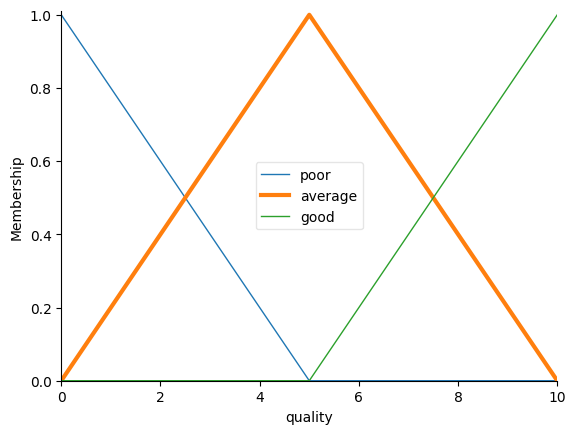

In [22]:
# You can see how these look with .view()
quality['average'].view()

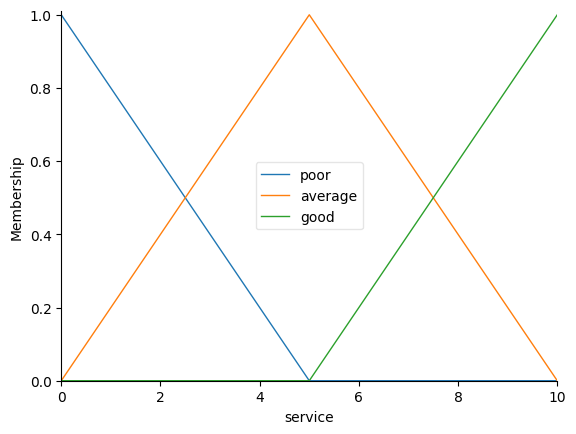

In [23]:
service.view()

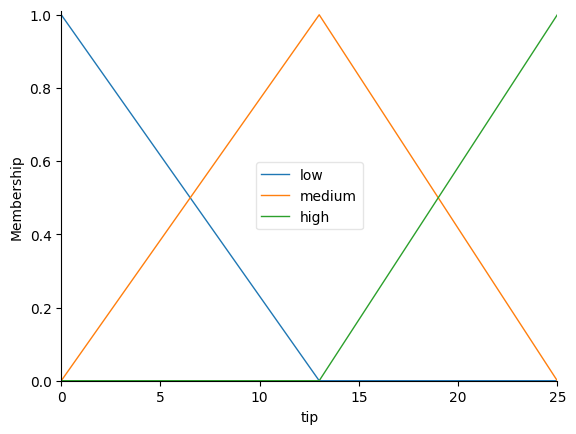

In [24]:
tip.view()

## Fuzzy rules

Now, to make these triangles useful, we define the *fuzzy relationship*
between input and output variables. For the purposes of our example, consider
three simple rules:

1. IF the food is poor OR the service is poor, THEN the tip will be low
2. IF the service is average, THEN the tip will be medium
3. IF the food is good OR the service is good, THEN the tip will be high.

Most people would agree on these rules, but the rules are fuzzy. Mapping the
imprecise rules into a defined, actionable tip is a challenge. This is the
kind of task at which fuzzy logic excels.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

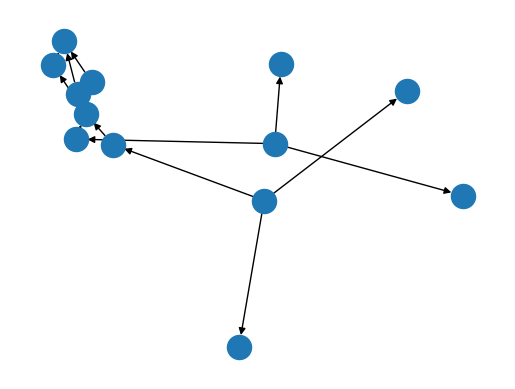

In [25]:
# Antecedent terms serving as inputs to this rule.
# Multiple terms may be combined using operators | (OR), & (AND), ~ (NOT), and parentheticals to group terms.

rule1 = ctrl.Rule(quality['poor'] | service['poor'], tip['low'])
rule2 = ctrl.Rule(service['average'], tip['medium'])
rule3 = ctrl.Rule(service['good'] | quality['good'], tip['high'])

rule1.view()

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

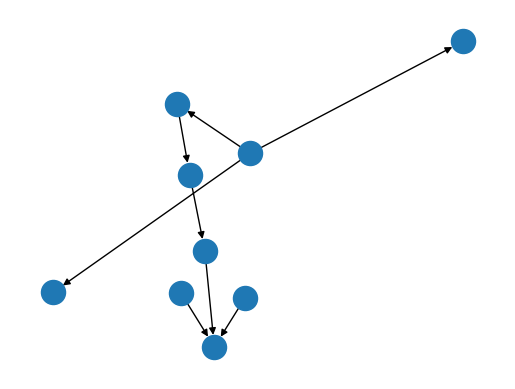

In [26]:
rule2.view()

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

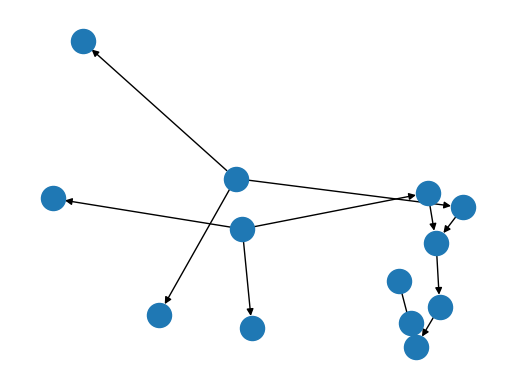

In [27]:
rule3.view()

### Control System Creation and Simulation
Now that we have our rules defined, we can simply create a control system
via:

In [28]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3]) # The inference block

In order to simulate this control system, we will create a`ControlSystemSimulation`. Think of this object representing our controller
applied to a specific set of circumstances. For tipping, this might be tipping Sharon at the local brew-pub. We would create another `ControlSystemSimulation` when we're trying to apply our `tipping_ctrl` for Travis at the cafe because the inputs would be different.

In [29]:
tipping = ctrl.ControlSystemSimulation(tipping_ctrl) # The whole Fuzzy Inference system

We can now simulate our control system by simply specifying the inputs and calling the `compute` method. 
Suppose we rated the quality 6.5 out of 10 and the service 9.8 of 10.

In [30]:
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input['quality'] = 6.5
tipping.input['service'] = 9.8

# Crunch the numbers
tipping.compute()

Once computed, we can view the result as well as visualize it.

19.847607361963192


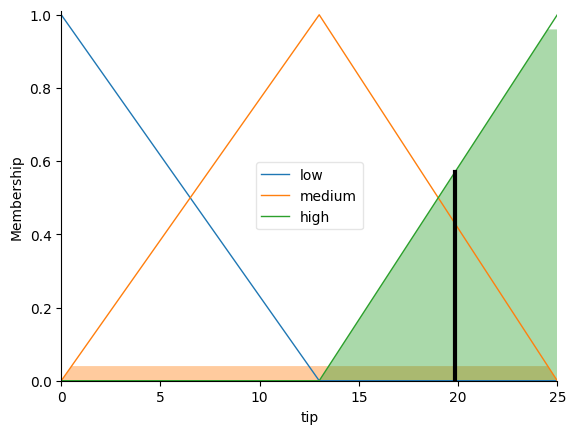

In [31]:
print(tipping.output['tip'])
tip.view(sim=tipping)

The resulting suggested tip is **19.84%**.

### Final thoughts

The power of fuzzy systems is allowing complicated, intuitive behavior based on a sparse system of rules with minimal overhead. Note our membership function universes were coarse, only defined at the integers, but `fuzz.interp_membership` allowed the effective resolution to increase on demand. This system can respond to arbitrarily small changes in inputs, and the processing burden is minimal.

In [32]:
tipping.inputs({'quality': 4, 'service': 8})
tipping.compute()
tipping.output['tip']

14.365356265356265

In [33]:
#tipping.print_state()